In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

<br>

# Categories of models
---

In terms of outputs, there are several board categories of approaches to the problem of classification:

1. **Discriminative**: just return the classification of the input
2. **Probabilistic Discriminative**: return a probability mass over the possible classifications
3. **Probabilistic generative**: return a model for the data generation process, which can be used for classification

The discriminative functions are arguably not useful enough as we lack the confidence of the model for the prediction. Such models will in effect create a decision boundary, and points will change from one category to the other in a non-smooth way.

The **probabilistic models** in general solves the issue of the first category by providing us with a smooth transition from one class to another. We can also use the returned probability mass $p(\mathcal{C}_k|x)$ to feed a **utility function** that allows to take more **rational decisions**.

The **generative models** go further and give us a generic model $p(x|\mathcal{C}_k)$. This model can be useful to generate new inputs for other processes (for instances generating images of cats). There are also usually **more stable** because they model **forward probabilities** $p(x|\mathcal{C}_k)$, the probablity that the cause is creating the effect. If the *a priori* probability $p(\mathcal{C}_k)$ changes, they will not be affected.

The counterpart is that they generally need a considerable amount of parameters to tune. But this is might be considerably more work to do, and might not be interesting if you only care about classification (see **GANS** for interesting parallels).

<br>

# Probabilistic models
---

Parts that are common to both generative and discriminative probabilistic models.

<br>

### The origin of Softmax

The softmax function is a way to get **smooth version of max** which is pretty handy for models that use gradient descent and therefore require a chain smooth functions from the input to the output:

&emsp; $\displaystyle \operatorname{softmax}(x_1 \dots x_n) = (y_1 \dots y_n)$
&emsp; where
&emsp; $\displaystyle y_i = \frac{\exp x_i}{\sum_j \exp x_j}$

The softmax function is also sound from a probabilitic perspective. It originates from linear models and is the Bayes' theorem under the assumption that the data is generated using a mixture of gaussian distributions with the same covariance matrix.

&emsp; $\displaystyle p(x|\mathcal{C}_k) = \mathcal{N}(\mu_k, \Sigma)$
&emsp; 
&emsp; $\displaystyle p(C_k|x) = \frac{p(x|C_k)p(C_k)}{\sum_i p(x|C_i)p(C_i)}$
&emsp; $\implies$
&emsp; $\displaystyle \boxed{p(C_k|x) = \frac{exp(a_k)}{\sum_i exp(a_i)}}$
&emsp; where
&emsp; $a_k = w_k^T x$

<br>

**Proof**: We start by matching $\exp(a_k) = p(x|C_k) p(C_k)$ and unroll the computation:

&emsp; $\displaystyle a_k = \log p(C_k) - \frac{D}{2} \log 2 \pi - \frac{1}{2} \log |\Sigma| -\frac{1}{2}(x - \mu_k)^T \Sigma^{-1} (x - \mu_k)$

&emsp; $\displaystyle a_k = \log p(C_k) - \frac{D}{2} \log 2 \pi - \frac{1}{2} \log |\Sigma| -\frac{1}{2} \big(x^T \Sigma^{-1} x + \mu_k^T \Sigma^{-1} \mu_k - 2 x^T \Sigma^{-1} \mu_k \big)$

We can simplify the terms by removing the common part between all $a_i$ (as they cancel out thanks to the ratio):

&emsp; $\displaystyle a_k = \log p(C_k) - \frac{1}{2} \big(\mu_k^T \Sigma^{-1} \mu_k - 2 \mu_k^T \Sigma^{-1} x \big)$
&emsp; $\implies$
&emsp; $a_k = w_k^T x + b_k$
&emsp; (affine form in $x$)

<br>

### The origin of Sigmoid

The sigmoid is a **smooth version of a step function** from 0 to 1. For binary classification, this is the smooth equivalent of a yes-no decision. As for softmax, the smoothness is handy for gradient descent:

&emsp; $\displaystyle \operatorname{sigmoid}(x) = \frac{1}{1 + e^{-x}} = \frac{e^x}{1 + e^x}$

As for softmax, this function has a sound probabilistic meaning. It corresponds to the Bayes' theorem under the assumption that the data is generated using a mixture of 2 gaussians with the same covariance matrix:

&emsp; $\displaystyle p(x|\mathcal{C}_k) = \mathcal{N}(\mu_k, \Sigma)$
&emsp; 
&emsp; $\displaystyle p(C_1|x) = \frac{p(x|C_1)p(C_1)}{p(x|C_1)p(C_1) + p(x|C_2)p(C_2)}$
&emsp; $\implies$
&emsp; $\displaystyle \boxed{p(C_1|x) = \frac{1}{1 + e^{-y}}}$
&emsp; where
&emsp; $y = w_k^T x$

**Proof**: We re-write the Bayes' theorem to make appear the ratio of posterior between the two classes:

&emsp; $\displaystyle p(C_1|x) = \frac{1}{1 + \frac{p(x|C_2)p(C_2)}{p(x|C_1)p(C_1)}}$
&emsp; $\implies$
&emsp; $\displaystyle p(C_1|x) = \frac{1}{1 + e^{-y}}$
&emsp; where
&emsp; $\displaystyle y = \log \frac{p(x|C_1)p(C_1)}{p(x|C_2)p(C_2)}$

We then unroll the expression of $y$, and using the fact that the covariance matrix $\Sigma$ we get:

&emsp; $\displaystyle y = \log \frac{p(C_1)}{p(C_2)} + \frac{1}{2} \mu_2^T \Sigma^{-1} \mu_2 - \frac{1}{2} \mu_1^T \Sigma^{-1} \mu_1 + (\mu_1 - \mu_2)^T \Sigma^{-1} x$
&emsp; $\implies$
&emsp; $y = w^T x + b_k$
&emsp; (affine form in $x$)

<br>

### Single linear decision boundary

As shown above, under the assumption that the generative process is a mixture of gaussians $p(C_k|x)$, all gaussians having identical covariance matrices, a simple linear boundary (an hyperplan in general) will be enough to separate the classes.

For two classes and one dimensional inputs, this line can be found by hand:

&emsp; $\displaystyle p(C_1|x) = \frac{1}{1 + e^{-y}} = 0.5 \implies e^{-y} = 1 \implies y = 0$

If we further assume that both class prior probabilities are equal $p(C_1) = p(C_2)$, we get:

&emsp; $\displaystyle (\mu_2 - \mu_1) x = \frac{1}{2}(\mu_2^2 - \mu_1^2) = \frac{1}{2}(\mu_2 - \mu_1)(\mu_2 + \mu_1)$
&emsp; $\implies$
&emsp; $\displaystyle x = \frac{\mu_1 + \mu_2}{2}$

The best decision binary between two values pertubated by noise is precisely in the middle of them if both values are equally likely to be send a priori. This has obvious implications when decoding messages sent over a noisy channel (one of the problem Shannon was interested in) under the assumption that the entropy of the message sent is maximized (that is, if both symbols have the same probability).

<br>

### Multiple linear decision boundaries

Similarly, when there are multiple classes, the decision boundary between two class can be found by searching for the points where the probabilities $p(C_i|x) = p(C_j|x)$. These are the points where $a_i = a_j$ in the softmax:

&emsp; $\displaystyle p(C_k|x) = \frac{exp(a_k)}{\sum_i exp(a_i)}$
&emsp; $\implies$
&emsp; $p(C_i|x) = p(C_j|x) \iff a_i = a_j \iff w_i^T x = w_j^T x \iff (w_i - w_j)^T x$

This decision boundary is the equation of an hyperplane, separating the regions where $\forall i, j : w_i^T x \ge w_j^T x$. The overall decision boundaries, once assembled all together can form much more complex patterns. Note the efficiency of the approach: with $N$ outputs, we can separate $N$ classes by creating ${N \choose 2} = \frac{1}{2}N(N+1)$ boundaries (one for each pair of classe).

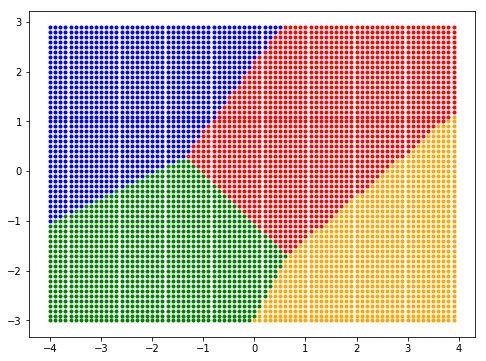

In [23]:
cov = [[2.0, 1.0],[1.0, 2.0]]
distributions = [
    stats.multivariate_normal([-2.,2.], cov),
    stats.multivariate_normal([-2.,-2.], cov),
    stats.multivariate_normal([1.,1.], cov),
    stats.multivariate_normal([3.,-2.], cov)
]

points = np.array([[x, y] for x in np.arange(-4, 4, 0.1) for y in np.arange(-3, 3, 0.1)])
classes = np.zeros(points.shape[0])
for i, point in enumerate(points):
    classes[i] = np.array([d.pdf(point) for d in distributions]).argmax()
    
fig, ax = plt.subplots(figsize=(8, 6))
for c_id, color in (0, 'blue'), (1, 'green'), (2, 'red'), (3, 'orange'):
    ax.scatter(points[classes==c_id][:,0], points[classes==c_id][:,1], color=color, marker='.')
plt.show()

<br>

### Non-linear decision boundaries

The moment we drop the assumption that the data generative process is a mixture of gaussian with equal covariance matrices, the linearity of the decision boundaries does not hold anymore. In practice, the simplest generative models will not have the same covariance matrices for each mixture, and for the more complex generative models, the distribution will not be gaussian and will likely have multiple modes.

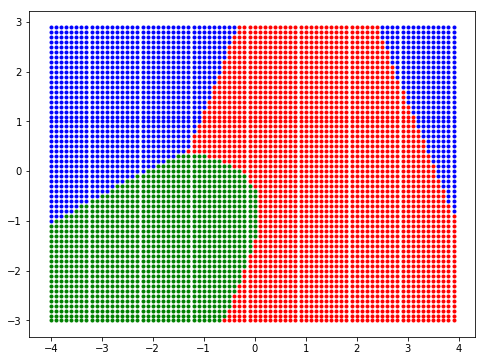

In [24]:
distributions = [
    stats.multivariate_normal([-2.,2.], [[100.0, 0.0],[0.0, 2.0]]),
    stats.multivariate_normal([-2.,-2.], [[3.0, 2.0],[2.0, 2.0]]),
    stats.multivariate_normal([1.,0.], [[1.0, 0.0],[0.0, 3.0]])
]

points = np.array([[x, y] for x in np.arange(-4, 4, 0.1) for y in np.arange(-3, 3, 0.1)])
classes = np.zeros(points.shape[0])
for i, point in enumerate(points):
    classes[i] = np.array([d.pdf(point) for d in distributions]).argmax()
    
fig, ax = plt.subplots(figsize=(8, 6))
for c_id, color in (0, 'blue'), (1, 'green'), (2, 'red'), (3, 'orange'):
    ax.scatter(points[classes==c_id][:,0], points[classes==c_id][:,1], color=color, marker='.')
plt.show()